# Clasificación no lineal, complejidad y sobreajuste

Definimos primero unas librerías y funciones que vamos a usar a durante la sesión:

In [1]:
# https://pypi.python.org/pypi/pydot-
!apt install graphviz
!pip install graphviz
!pip install pydot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn import datasets
from sklearn.datasets import make_moons
import graphviz 
from sklearn.tree import export_graphviz
import pydot


# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    print(X.shape)
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

Un modelo de clasificación puede ser tan complejo como para aprenderse de memoria el conjunto de entrenamiento. Esta complejidad está determinada por los parámetros internos del modelo. A continuación, observaremos cómo se comporta esta complejidad usando un modelo clasificación no lineal como lo es  *k-vecinos más cercanos* (K-nearest neighbors en inglés)

## Definición del conjunto de datos

Vamos a trabajar con un conjunto de datos artificial. El conjunto es creado usando la funcionalidad `make_moons` de Scikit-Learn. `make_moons` permite introducir algo de ruido sobre las muestras creadas.

In [0]:
X, y = make_moons(n_samples=600, noise=0.3, random_state=0)

In [5]:
print('X ~ n_muestras x n_características:', X.shape)
print('y ~ n_muestras:', y.shape)

print('\nPrimeras 5 muestras:\n', X[:5, :])
print('\nPrimeras 5 etiquetas:', y[:5])

X ~ n_muestras x n_características: (600, 2)
y ~ n_muestras: (600,)

Primeras 5 muestras:
 [[ 0.70558369 -0.57087449]
 [ 0.17553063  1.0055569 ]
 [-0.5316905   0.81385807]
 [ 1.075774   -0.88368429]
 [-0.14128686  0.62790384]]

Primeras 5 etiquetas: [1 0 0 1 0]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


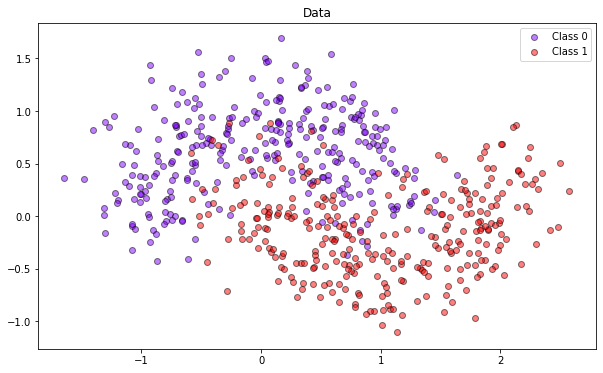

In [6]:
pl.figure(figsize = (10, 6))  
plot_data(X, y)

Observamos que es dificil establecer una separación lineal, como la que se obtiene con regresión logística:

(600, 2)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Score: 0.8666666666666667


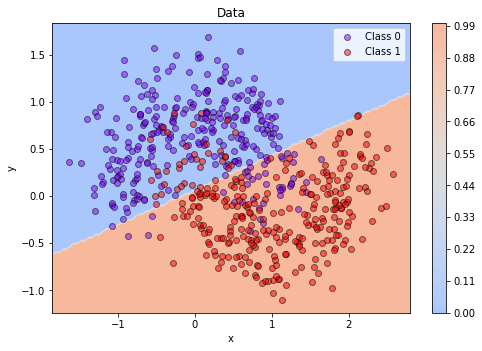

In [8]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs');
lr_model.fit(X, y)
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, gen_pred_fun(lr_model))
plot_data(X, y)
print("Score:",lr_model.score(X, y))

 Por lo tanto es necesario usar un modelo de clasificación no lineal.

# Algoritmo: K-vecinos más cercanos

La clasificación basada en vecinos es un tipo de aprendizaje basado en ejemplos. El modelo almacena los ejemplos vistos durante entrenamiento y clasifica un elemento no visto, usando una simple regla de votación por mayoría. Si se ubica un **punto** en el espacio de características, se le asigna como clase el valor de la clase que tenga la mayor cantidad de ejemplos en la vecindad del punto. Este ejemplo lo podemos ver ilustrado en la imagen:

<img src="https://drive.google.com/uc?export=view&id=10I5967XssKpLQLivqER1uwfEw9qIsARd">

Scikit-Learn provee una implementación del algoritmo conocida como `KNeighborsClassifier`. `KNeighborsClassifier` tiene un parámetro $n\_neighbors$ o $k$, dónde $k$ es un entero definido por el usuario que determina cuántos vecinos evalua para determinar la clase de una instancia nunca antes vista. La elección de este parámetro es definida totalmente por la naturaleza de los datos.

Observaremos que dependiendo del valor de vecinos más cercanos, conseguimos diferentes funciones de ajuste, unas más suaves que otras. Vamos a evaluar el efecto del parámetro $k$ en la complejidad del modelo. 

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
knn = KNeighborsClassifier(n_neighbors=1)

Vamos a extraer un porcentaje al azar del conjunto de datos. 

In [11]:
idx = np.random.choice(len(X), int(len(X)*.5), replace=False)
X_reduced = X[idx]
y_reduced = y[idx]
print(X_reduced.shape)

(300, 2)


Entrenamos un modelo `knn` llamando la función `fit()` sobre el conjunto de datos reducido

In [12]:
knn.fit(X_reduced, y_reduced)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

(300, 2)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


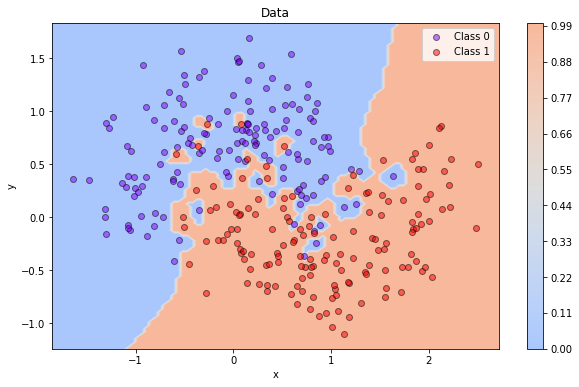

In [13]:
pl.figure(figsize = (10, 6))
plot_decision_region(X_reduced, gen_pred_fun(knn))
plot_data(X_reduced, y_reduced)

In [14]:
print('Error: {}'.format(1 - knn.score(X_reduced, y_reduced)))

Error: 0.0


**¿Tiene sentido que el error sea del $0\%$?**

Ahora agreguemos los datos que descartamos anteriormente

(300, 2)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


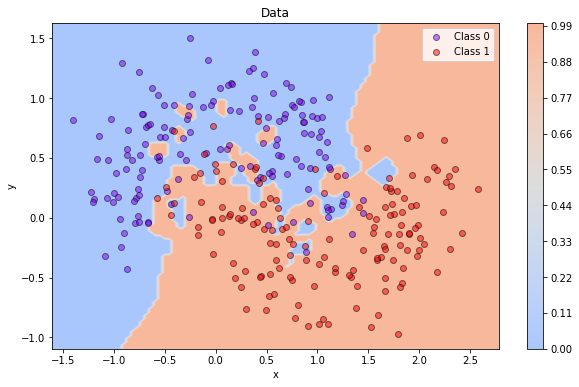

In [15]:
idx_c = [i for i in range(len(X)) if i not in idx]
X_complement = X[idx_c]
y_complement = y[idx_c]

pl.figure(figsize = (10, 6))   
plot_decision_region(X_complement, gen_pred_fun(knn))
plot_data(X_complement, y_complement)

In [16]:
print('Error: {}'.format(1 - knn.score(X_complement, y_complement)))

Error: 0.1333333333333333


Podemos observar que cuando el número de vecinos es $1$, el modelo se ajusta demasiado al ruído de los datos de entrada, por lo tanto sufre de **sobreajuste**.

# Error de entrenamiento y generalización

Un modelo de aprendizaje de máquina tiene como objetivo principal hacer predicciones de manera acertada sobre ejemplos nunca antes vistos por el modelo. Esto se conoce como error de generalización. Para poder medir el error de generalización, dividimos el conjunto de datos en dos particiones: 

* **Entrenamiento**: Se usará para entrenar el modelo.
* **Prueba**: Se usará para medir el error de generalización.

En la siguiente imagen encontramos una ilustración de cómo se hace un particionamiento en entrenamiento y prueba.

<img src="https://drive.google.com/uc?export=view&id=1wTnv5b52qkLDhgkBgHvA6zs_BEW9a44R">

Una de las prácticas recomendadas, es particionar los datos $70\%$ para entrenamiento y $30\%$ para prueba. Cuando el número de muestras es muy grande ($\ge 70K$), podemos reducir el porcentaje de muestras para prueba, a $90-10\%$. Sin embargo, deben hacerse unas aclaraciones sobre la generalización:

* El conjunto de prueba debe ser una muestra representativa del conjunto de datos. El muestreo de ejemplos debe hacerse de forma independiente e idénticamente aleatoria de una distribución. Esto quiere decir, que el muestreo de un ejemplo no está influenciado por el muestreo de otro.
* La distribución es estacionaria. Es decir no cambia a lo largo del conjunto de datos.
* Los ejemplos son muestreados desde particiones de la misma distribución. Es decir, no se deben crear nuevas características en la partición de prueba.

Adicionalmente, debemos tener en cuenta que se conserve la distribución de las etiquetas de los datos tanto en entrenamiento como en prueba (estratificación). Scikit-Learn nos permite particionar un conjunto de datos en entrenamiento y prueba. A continuación, vamos a dividir el conjunto en $70\%$ para entrenamiento y $30\%$ para prueba.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

#### Parámetros:

* `test_size`: Tamaño de la partición de prueba
* `random_state`: Semilla del generador de números pseudoaleatorios. Este parámetro garantiza reproducibilidad del particionamiento.
* `stratify`: Si se estratifican los datos con respecto a `y`

Vamos a verificar el número de muestras de ambas particiones y la distribución de clases de cada una.

In [18]:
print('Número de muestras en entrenamiento: {}'.format(X_train.shape[0]))
print('Número de muestras en prueba: {}'.format(X_test.shape[0]))
print('Número de características: {}'.format(X_train.shape[1]))

print('Distribución de clases en entrenamiento: {}'.format(np.bincount(y_train)))
print('Distribución de clases en prueba: {}'.format(np.bincount(y_test)))

Número de muestras en entrenamiento: 420
Número de muestras en prueba: 180
Número de características: 2
Distribución de clases en entrenamiento: [210 210]
Distribución de clases en prueba: [90 90]


Usamos la partición recién creada y analizamos un modelo entrenado con $k = 200$.

In [20]:
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=200, p=2,
                     weights='uniform')

(420, 2)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


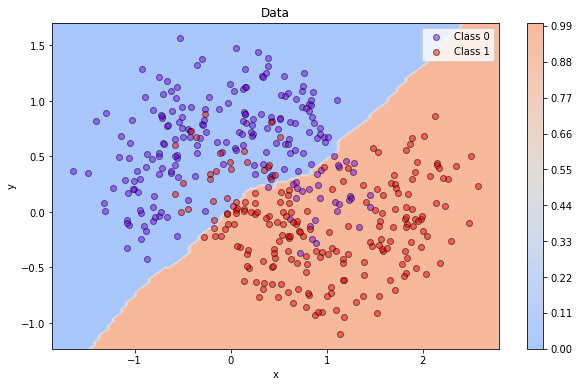

In [21]:
pl.figure(figsize = (10, 6)) 
plot_decision_region(X_train, gen_pred_fun(knn))
plot_data(X_train, y_train)

In [22]:
print('Error en entrenamiento: {}'.format(1-knn.score(X_train, y_train)))

Error en entrenamiento: 0.14761904761904765


Observamos que el error en entrenamiento es del $14\%$. Además se evidencia que el modelo entrenado es ahora demasiado **simple** y no se puede ajustar a la estructura de los datos.

Ahora medimos el error de generalización del modelo entrenado y visualizamos la clasificación de los datos de prueba.

(180, 2)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


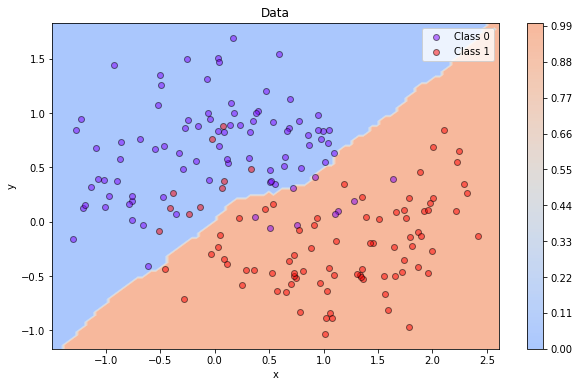

In [23]:
pl.figure(figsize = (10, 6))   
plot_decision_region(X_test, gen_pred_fun(knn))
plot_data(X_test, y_test)

In [24]:
print('Error de generalización: {}'.format(1 - knn.score(X_test, y_test)))

Error de generalización: 0.10555555555555551


Podemos observar que cuando aumentamos el número de vecinos, nuestro modelo sufre de **subajuste**. La superficie de decisión se suaviza, pero no logra captar los detalles de los datos. Mientras el error de entrenamiento se acerca a $14\%$, el error de generalización se acerca a $10\%$.

**¿Cómo estimar un buen número de $k$-vecinos más cercanos de manera que el modelo no sobreajuste ni subajuste los datos?**

# Evaluación de la complejidad

Un modelo de aprendizaje de máquina puede ser tan complejo como para recordar las particularidades y el ruido del conjunto de entrenamiento (**sobreajuste**), así como puede ser demasiado flexible para no modelar la variabilidad de los datos (**subajuste**). El modelo debe garantizar un compromiso entre el sobreajuste y el subajuste, lo cual se logra evaluando la complejidad del modelo. Una forma de evaluar la complejidad es analizar el error de entrenamiento y generalización para diferentes modelos que varían en su complejidad. En el caso de `KNearestNeighbor`, la complejidad está determinada por el número de vecinos $k$. **Entre menor sea el número de vecinos, más complejo es el modelo.**

A continuación, exploramos un conjunto de valores $k$, con el objetivo de encontrar aquél modelo con el mejor compromiso entre error de entrenamiento y error de generalización.

In [25]:
k_values = list(range(1, 200))
print(k_values)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


Vamos a generar un nuevo conjunto de datos con $1000$ muestras y haremos una partición $70-30$.

In [0]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

Evaluamos el error de entrenamiento y generalización para diferentes valores de complejidad del modelo:

In [0]:
train_error = []
generalization_error = []

for nn in k_values:
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(X_train, y_train)
    train_error.append(1 - knn.score(X_train, y_train))
    generalization_error.append(1 - knn.score(X_test, y_test))

Visualizamos ambas curvas de aprendizaje.

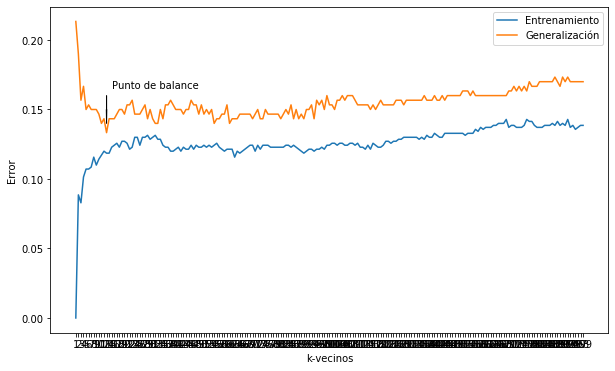

In [28]:
pl.figure(figsize = (10, 6))

pl.plot(k_values, train_error, label="Entrenamiento")
pl.plot(k_values, generalization_error, label="Generalización")
pl.xticks(k_values)
pl.xlabel("k-vecinos")
pl.ylabel("Error")
#pl.gca().invert_xaxis()
pl.arrow(13, 0.16, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(15, 0.165, 'Punto de balance')
pl.legend();

Se observa que el error de entrenamiento es más alto para modelos más simples ( valor de k alto) y tiende a cero para modelos más complejos (valor bajo de k). Encontramos que el error de validación es alto en ambos extremos, y tiene su punto de balance mínimo en $k=13$. 

# Árboles de Decisión

A continuación, se presenta otro algoritmo de clasificación no lineal basado en árboles de decisión. Los árboles de decisión son muy intuitivos, puesto que codifican una serie de elecciones "**si esto**" o "**si no entonces**", de forma muy similar a como una persona tomaría una decisión. La gran ventaja de esta técnica es que estas elecciones se pueden aprender de forma automática desde los datos.

## Ejemplo

Considere el siguiente árbol de decisión. Este árbol de decisión describe una serie de elecciones que buscan determinar si espero (**V**) o no (**F**) por una mesa en un restaurante.

<img src="https://drive.google.com/uc?export=view&id=1XrQiEx-PRqJDjSaoXvhh2a_YxxNlRUy0">

Con base al anterior árbol de decisión, puedo tomar la decisión de si espero o no, usando unas reglas de clasificación sencillas, por ejemplo:

* **Si** Clientes = "Lleno" **Y** EsperaEstimada = "10-30" **Y** Hambre = "No" **Entonces** Esperar="SI"
* **Si** Clientes = "Algunos" **Entonces** Esperar="SI"
* **Si** Clientes = "Lleno" **Y** EsperaEstimada = ">60" **Entonces** Esperar="NO"

## Beneficios

* Los datos de entrada requieren muy poco preprocesamiento. Los árboles de decisión pueden trabajar con variables de diferente tipo (continuas y variables) y son invariantes al escalamiento de las características. 
* Los modelos son fáciles de interpretar, los árboles pueden ser visualizados.
* El costo computacional del uso del árbol para predecir la categoría de un ejemplo es mínimo comparado con otras técnicas (Tiempo logaritmico).

## Contras

* Puede ser tan complejo, que se memoriza el conjunto de datos, por lo tanto no generaliza tan bien (**Sobreajuste**).
* Son muy sensibles al imbalance de clases (**Sesgo**).

## ¿Cómo se construye el árbol? - Algoritmo básico
* El árbol es construido de arriba hacia abajo recursivamente de forma divide y vencerás.
* Al comienzo, todos los ejemplos de entrenamiento están en la raíz.
* Los atributos son categóricos (en caso de atributos continuos, se discretizan por adelantado)
* Los ejemplos son repartidos recursivamente de acuerdo con el atributo seleccionado. 
* Los atributos de prueba son seleccionados en base a una heurística o medida estadística (ej. **ganancia de información**)
* Se detiene hasta que solo hayan ejemplos de una clase en cada nodo hoja o se haya alcanza la profundidad máxima.

## ¿Cómo seleccionar un atributo? ¿Cómo medir si una partición es buena?

Una partición ideal es aquella que divide en un nodo las muestras de una misma clase. Observemos qué pasa si usamos la variable **Cliente** para particionar nuestro conjunto de datos.

<img src="https://drive.google.com/uc?export=view&id=1gXyErBV3z1pUa9Gh2ax0AB1O1_0aHBR2">

Ahora, observemos qué pasa cuando particionamos el conjunto de datos usando la variable **Tipo de restaurante**.

<img src="https://drive.google.com/uc?export=view&id=18wDWMDaDBY_N2PF_uPr-oV-PDTNV0wSm">

**¿Cuál variable es mejor?**

## Implementación en Scikit-Learn

La implementación de Scikit-Learn se consigue con la clase `DecisionTreeClassifier`.

In [0]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()

Cargamos de nuevo nuestro conjunto de datos usando IRIS.

In [0]:
iris = datasets.load_iris()
X = iris.data[:,[0, 2]] 
y = iris.target

`DecisionTreeClassifier` soporta varios parámetros como lo son:
* `max_depth`: Profundidad máxima del árbol.
* `criterion`: Medida para determinar la calidad del particionamiento generado por un atributo. Soporta coeficiente GINI y entropía.
* `min_samples_split`: Controla el número mínimo de muestras que debe haber en un nodo luego de una partición.
* `min_samples_leaf`: Controla el número mínimo de muestras que debe haber en un nodo hoja.

In [31]:
classifier.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [0]:
classifier = classifier.fit(X, y)

Visualizamos la superficie de decisión del clasificador

(150, 2)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


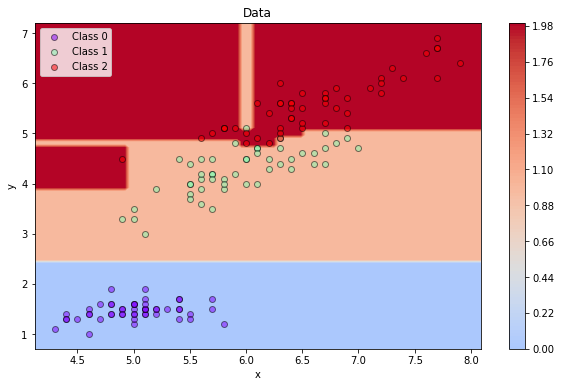

In [33]:
pl.figure(figsize = (10, 6))    
plot_decision_region(X, gen_pred_fun(classifier))
plot_data(X, y)

In [34]:
print('Error: {}'.format(1-classifier.score(X, y)))

Error: 0.00666666666666671


## Visualización

El árbol de decisión aprendido puede ser visualizado usando `graphviz`. En Ubuntu, se recomienda instalarlo usando ambas líneas:
* `conda install graphviz`
* `sudo apt-get install graphviz`

A continuación, vamos a usar el conjunto de datos IRIS completo (Usando las cuatro características) y entrenamos un árbol de decisión.

In [0]:
X = iris.data
y = iris.target

classifier = DecisionTreeClassifier()
classifier = classifier.fit(X, y)

Usamos `graphviz` para visualizar el árbol generado. `graphviz` soporta como parámetros los nombres de las clases y de las características

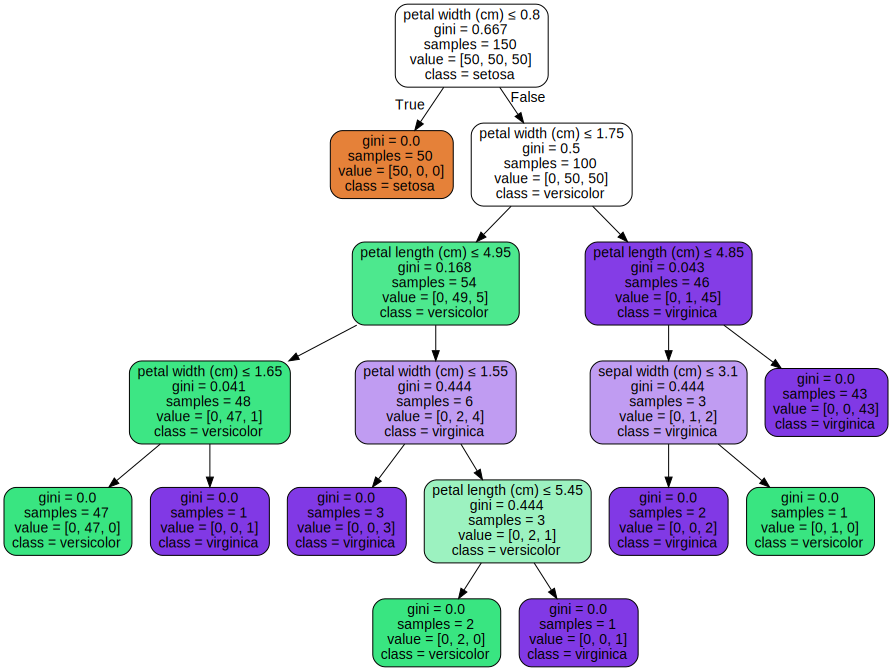

In [36]:
from IPython.display import SVG
dot_data = export_graphviz(classifier, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))

## Importancia de las variables

Una de las ventajas de usar árboles de decisión, es que nos permite determinar la importancia de cada característica, con base al índice de impureza usado. Scikit-Learn nos permite acceder a la importancia de cada característica llamando `.feature_importances_`. Esta importancia cuantifica qué tanto aporta cada característica a mejorar el desempeño del árbol.

In [37]:
classifier.feature_importances_

array([0.        , 0.01333333, 0.06405596, 0.92261071])

In [0]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

## Evaluación de la complejidad usando `DecisionTreeClassifier`

Para evaluar la complejidad, vamos a estimar la profundidad óptima del árbol.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

In [39]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

Vamos a explorar los siguientes valores de profundidad máxima:
* $[1, 2, 3, \dots, 20]$

In [0]:
train_error = []
generalization_error = []
max_depth_values = list(range(1, 21, 1))

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    train_error.append(1 - decision_tree.score(X_train, y_train))
    generalization_error.append(1 - decision_tree.score(X_test, y_test))

Visualizamos la curva de error de entrenamiento contra error de generalización

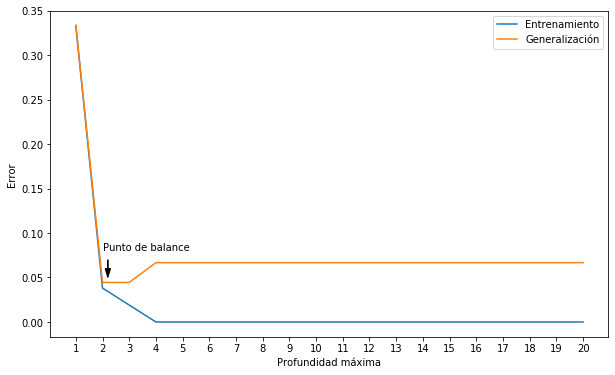

In [41]:
pl.figure(figsize = (10, 6))

pl.plot(max_depth_values, train_error, label="Entrenamiento")
pl.plot(max_depth_values, generalization_error, label="Generalización")
pl.xticks(max_depth_values)
pl.xlabel("Profundidad máxima")
pl.ylabel("Error")
pl.arrow(2.2, 0.07, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(2, 0.08, 'Punto de balance')
pl.legend();